Device: cpu
Loading and preparing data...
Fetching YFinance data from 2021-07-01 to 2025-10-04...

STARTING ABLATION STUDY (5 MODELS)...

RUNNING: 0. NVDA Only
Epoch 30/90: Loss 0.00094
Epoch 60/90: Loss 0.00073
Epoch 90/90: Loss 0.00072
>>> Result: Alpha Mult=1.079x | Raw Mult=1.317x
Model saved to saved_models_new/0_NVDA_Only.pt

RUNNING: 1. Market Only
Epoch 30/90: Loss 0.00071
Epoch 60/90: Loss 0.00073
Epoch 90/90: Loss 0.00063
>>> Result: Alpha Mult=1.313x | Raw Mult=1.400x
Model saved to saved_models_new/1_Market_Only.pt

RUNNING: 2. Market + SEC
Epoch 30/90: Loss 0.00089
Epoch 60/90: Loss 0.00068
Epoch 90/90: Loss 0.00061
>>> Result: Alpha Mult=1.615x | Raw Mult=1.701x
Model saved to saved_models_new/2_Market_+_SEC.pt

RUNNING: 3. Market + News
Epoch 30/90: Loss 0.00075
Epoch 60/90: Loss 0.00066
Epoch 90/90: Loss 0.00064
>>> Result: Alpha Mult=1.273x | Raw Mult=1.405x
Model saved to saved_models_new/3_Market_+_News.pt

RUNNING: 4. Full Model
Epoch 30/90: Loss 0.00071
Epoch 60/90

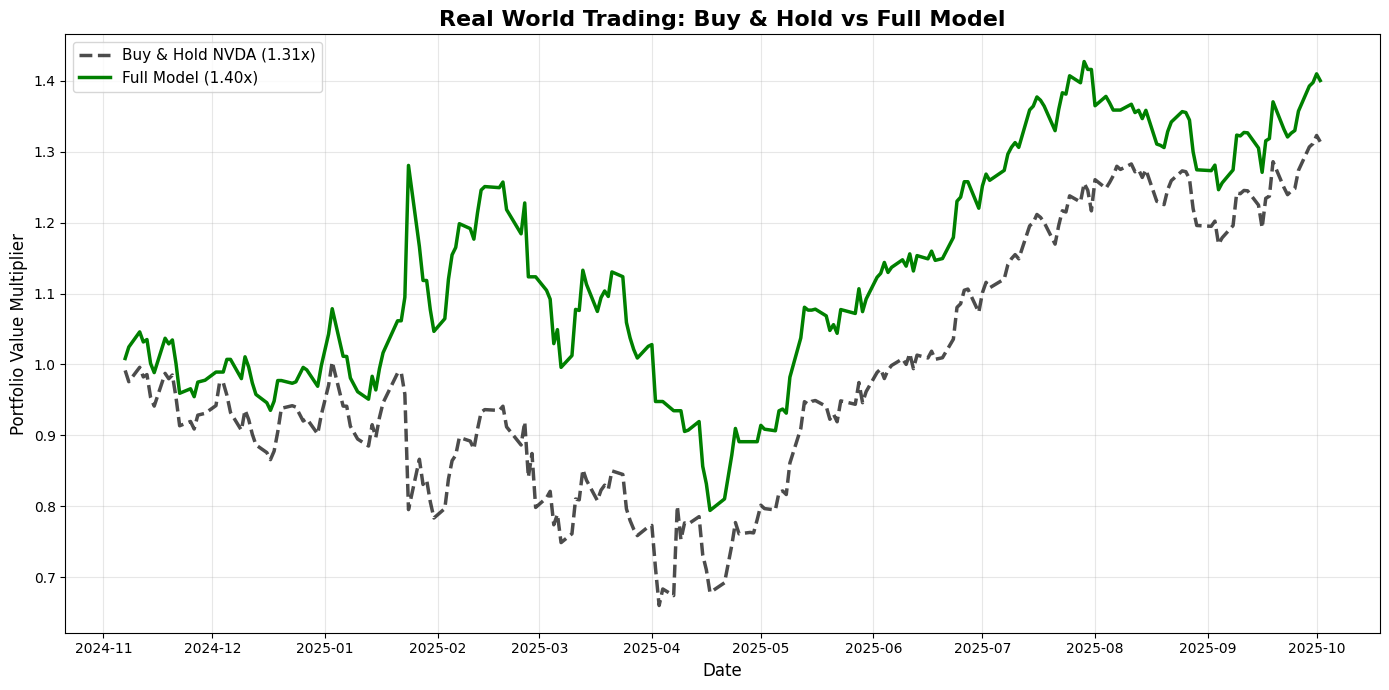

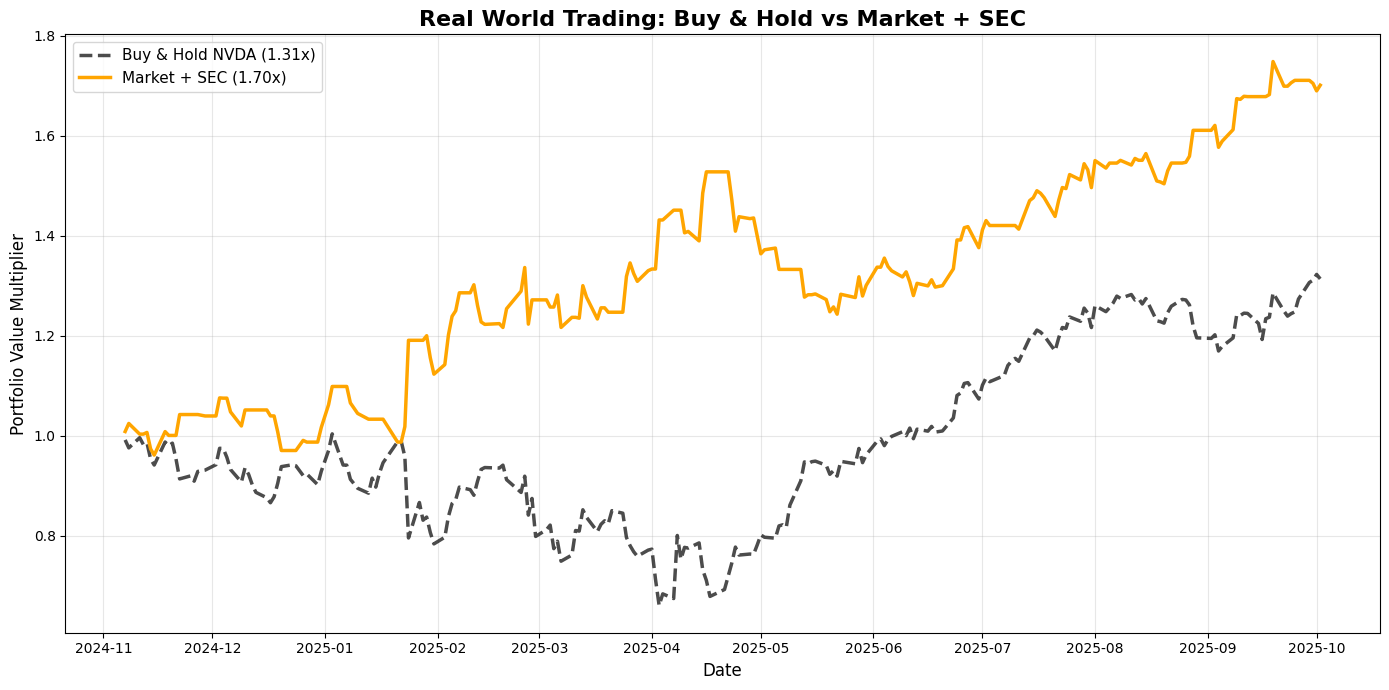

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import warnings
import random
import os

warnings.filterwarnings('ignore')
os.makedirs("saved_models_new", exist_ok=True)

# ==========================================
# 0. REPRODUCIBILITY LOCK
# ==========================================
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True, warn_only=True)

SEED = 241
set_seed(SEED)

# ==========================================
# 1. CONFIGURATION
# ==========================================
TRAIN_PATHS = {
    'AMD': "dataset/amd_train.csv",
    'NVDA': "dataset/nvidia_train.csv",
    'QQQ': "dataset/qqq_train.csv",
    'TSM': "dataset/tsm_train.csv"
}
TEST_PATHS = {
    'AMD': "dataset/amd_test.csv",
    'NVDA': "dataset/nvidia_test.csv",
    'QQQ': "dataset/qqq_test.csv",
    'TSM': "dataset/tsm_test.csv"
}

TRAIN_END = '2024-10-04'
TEST_START = '2024-10-10'
YF_START = '2021-07-01'
YF_END = '2025-10-04'

SEC_COLS = ['Capital_Return_Policy', 'Earnings_Surprise', 'Legal_or_ESG_Issues', 'Strategic_Announcements']
BASE_MKT_COLS = ['Return', 'Return_AMD', 'Return_TSM', 'Return_QQQ',
                 'Spread_AMD', 'Spread_TSM',
                 'RSI', 'Vol_Ratio', 'WilliamsR', 'Vol_Shock']
# NEW: NVDA-only market features (no cross-asset data)
NVDA_ONLY_COLS = ['Return', 'RSI', 'WilliamsR', 'Vol_Shock']

LOOKBACK = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 90
NVDA_BETA = 1.2

# ==========================================
# 2. DATA UTILITIES
# ==========================================
def fetch_yfinance_data(tickers, start_date, end_date):
    print(f"Fetching YFinance data from {start_date} to {end_date}...")
    try:
        data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', progress=False)
    except Exception as e:
        print(f"Error fetching data: {e}")
        return {}

    clean_data = {}
    if len(tickers) == 1:
        t = tickers[0]
        df = data.copy().reset_index()
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
            clean_data[t] = df[['Date', 'High', 'Low', 'Open', 'Volume']]
    else:
        for t in tickers:
            if t in data:
                df = data[t].copy().reset_index()
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
                    clean_data[t] = df[['Date', 'High', 'Low', 'Open', 'Volume']]
    return clean_data

def parse_embedding(emb_str):
    if isinstance(emb_str, str):
        cleaned = emb_str.replace('[', '').replace(']', '').replace('\n', ' ')
        try:
            return np.fromstring(cleaned, sep=' ')
        except:
            return np.zeros(768)
    return np.zeros(768)

# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================
def compute_technical_alpha(df):
    if 'High' not in df.columns: df['High'] = df['Close']
    if 'Low' not in df.columns: df['Low'] = df['Close']
    if 'Volume' not in df.columns: df['Volume'] = 1.0

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    prev_close = df['Close'].shift(1)
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - prev_close).abs()
    tr3 = (df['Low'] - prev_close).abs()
    df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['ATR'] = df['TR'].rolling(14).mean()

    period = 14
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    denom = (highest_high - lowest_low).replace(0, 1)
    df['WilliamsR'] = ((highest_high - df['Close']) / denom) * -100

    vol_avg = df['Volume'].rolling(20).mean().replace(0, 1)
    df['Vol_Shock'] = df['Volume'] / vol_avg

    return df.fillna(0)

def load_and_combine_csvs(train_paths, test_paths):
    combined = {}
    for ticker in train_paths.keys():
        train_df = pd.read_csv(train_paths[ticker])
        test_df = pd.read_csv(test_paths[ticker])
        train_df['Date'] = pd.to_datetime(train_df['Date'])
        test_df['Date'] = pd.to_datetime(test_df['Date'])
        full_df = pd.concat([train_df, test_df], ignore_index=True)
        full_df = full_df.drop_duplicates(subset='Date').sort_values('Date').reset_index(drop=True)
        combined[ticker] = full_df
    return combined

def prepare_full_dataset(combined_csvs):
    tickers = list(combined_csvs.keys())
    yf_data = fetch_yfinance_data(tickers, YF_START, YF_END)

    dfs = {}
    for ticker, df in combined_csvs.items():
        df = df.copy()
        if ticker in yf_data:
            extra_data = yf_data[ticker]
            df = pd.merge(df, extra_data, on='Date', how='left')
            df[['High', 'Low', 'Open', 'Volume']] = df[['High', 'Low', 'Open', 'Volume']].ffill()

        df = df.sort_values('Date')
        if 'Close' not in df.columns and 'close' in df.columns:
            df.rename(columns={'close': 'Close'}, inplace=True)
        df['Close'] = df['Close'].replace(0, np.nan).ffill()
        df['Return'] = df['Close'].pct_change().fillna(0)

        dfs[ticker] = df[['Date', 'Close', 'Return']]

        if ticker == 'NVDA':
            df = compute_technical_alpha(df)
            if 'embedding' in df.columns:
                df['embedding_vec'] = df['embedding'].apply(parse_embedding)
            else:
                df['embedding_vec'] = [np.zeros(768) for _ in range(len(df))]

            # Create impact log score
            if 'avg_impact_score' in df.columns:
                df['impact_log'] = np.log1p(df['avg_impact_score'].fillna(0) * 100)
            else:
                df['impact_log'] = 0

            for sc in SEC_COLS:
                df[sc] = (df[sc] != 0).astype(int) if sc in df.columns else 0
            dfs['NVDA_RICH'] = df

    base = dfs['NVDA_RICH'].copy()
    base = base.merge(dfs['AMD'][['Date', 'Return']], on='Date', how='inner', suffixes=('', '_AMD'))
    base = base.merge(dfs['TSM'][['Date', 'Return']], on='Date', how='inner', suffixes=('', '_TSM'))
    base = base.merge(dfs['QQQ'][['Date', 'Return']], on='Date', how='inner', suffixes=('', '_QQQ'))

    base['Target_Residual'] = base['Return'] - (NVDA_BETA * base['Return_QQQ'])
    base['Spread_AMD'] = base['Return'] - base['Return_AMD']
    base['Spread_TSM'] = base['Return'] - base['Return_TSM']

    qqq_vol = base['Return_QQQ'].rolling(20).std()
    base['Vol_Ratio'] = (base['ATR'] / base['Close']) / qqq_vol.replace(0, 1)

    base.dropna(inplace=True)
    return base

def split_by_date(full_df, train_end, test_start):
    full_df['Date'] = pd.to_datetime(full_df['Date'])
    train_df = full_df[full_df['Date'] <= train_end].copy().reset_index(drop=True)
    test_df = full_df[full_df['Date'] >= test_start].copy().reset_index(drop=True)
    return train_df, test_df

# ==========================================
# 4. DYNAMIC TENSOR CREATION
# ==========================================
def create_sequences_dynamic(df, feature_cols, lookback=10, scaler=None, is_train=True):
    # Dynamically select columns based on ablation mode
    if is_train:
        scaler = StandardScaler()
        mkt_data = scaler.fit_transform(df[feature_cols].values)
    else:
        if scaler is None: raise ValueError("Scaler required")
        mkt_data = scaler.transform(df[feature_cols].values)

    news_data = np.stack(df['embedding_vec'].values)

    # Store Raw NVDA Returns for reconstruction plot
    raw_returns = df['Return'].shift(-1).fillna(0).values

    # Targets (Alpha)
    targets_residual = df['Target_Residual'].shift(-1).fillna(0).values
    dates = df['Date'].iloc[lookback:-1].values

    X_m, X_n, y_res, raw_ret = [], [], [], []
    for i in range(len(df) - lookback - 1):
        X_m.append(mkt_data[i : i+lookback])
        X_n.append(news_data[i : i+lookback])
        y_res.append(targets_residual[i + lookback])
        raw_ret.append(raw_returns[i + lookback])

    return (torch.tensor(np.array(X_m), dtype=torch.float32),
            torch.tensor(np.array(X_n), dtype=torch.float32),
            torch.tensor(np.array(y_res), dtype=torch.float32),
            np.array(raw_ret),
            dates), scaler

class StockDataset(Dataset):
    def __init__(self, xm, xn, y):
        self.xm, self.xn, self.y = xm, xn, y
    def __len__(self): return len(self.xm)
    def __getitem__(self, i): return self.xm[i], self.xn[i], self.y[i]

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ==========================================
# 5. MODEL ARCHITECTURES
# ==========================================
class StandardLSTM(nn.Module):
    def __init__(self, mkt_dim, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(mkt_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.0)
        self.dropout = nn.Dropout(0.2)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Tanh()
        )
    def forward(self, x_m, x_n=None):
        lstm_out, (h_n, _) = self.lstm(x_m)
        state = self.dropout(h_n[-1])
        return self.head(state) * 0.1

class GatedNewsNet(nn.Module):
    def __init__(self, mkt_dim, news_dim=768, hidden_dim=128):
        super().__init__()
        self.market_lstm = nn.LSTM(mkt_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.0)
        self.lstm_dropout = nn.Dropout(0.2)
        self.news_reduce = nn.Linear(news_dim, hidden_dim)
        self.gate_fc = nn.Linear(hidden_dim * 2, 1)
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Tanh()
        )

    def forward(self, x_m, x_n):
        lstm_out, (h_n, _) = self.market_lstm(x_m)
        market_state = self.lstm_dropout(h_n[-1])
        news_reduced = F.relu(self.news_reduce(x_n))
        attn_scores = torch.bmm(news_reduced, market_state.unsqueeze(2))
        attn_weights = F.softmax(attn_scores, dim=1)
        news_context = torch.sum(news_reduced * attn_weights, dim=1)
        gate_input = torch.cat([market_state, news_context], dim=1)
        gate_val = torch.sigmoid(self.gate_fc(gate_input))
        gated_news = news_context * gate_val
        combined = torch.cat([market_state, gated_news], dim=1)
        return self.fusion(combined) * 0.1

def directional_huber_loss(pred, target, lambda_dir=2.0):
    huber = F.huber_loss(pred, target, reduction='none')
    sign_mismatch = (torch.sign(pred) != torch.sign(target)).float()
    loss = huber * (1 + lambda_dir * sign_mismatch)
    return loss.mean()

# ==========================================
# 6. EXECUTION: ABLATION STUDY
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

print("Loading and preparing data...")
combined_csvs = load_and_combine_csvs(TRAIN_PATHS, TEST_PATHS)
full_df = prepare_full_dataset(combined_csvs)
train_df, test_df = split_by_date(full_df, TRAIN_END, TEST_START)

ABLATION_MODES = {
    "0. NVDA Only": { "features": NVDA_ONLY_COLS, "model_type": "Standard" },
    "1. Market Only": { "features": BASE_MKT_COLS, "model_type": "Standard" },
    "2. Market + SEC": { "features": BASE_MKT_COLS + SEC_COLS, "model_type": "Standard" },
    "3. Market + News": { "features": BASE_MKT_COLS + ['impact_log'], "model_type": "Gated" },
    "4. Full Model": { "features": BASE_MKT_COLS + ['impact_log'] + SEC_COLS, "model_type": "Gated" }
}

results_store = {}

print("\nSTARTING ABLATION STUDY (5 MODELS)...")

for mode_name, config in ABLATION_MODES.items():
    print(f"\n" + "="*50)
    print(f"RUNNING: {mode_name}")
    print("="*50)

    set_seed(SEED)

    cols = config['features']
    (X_m_tr, X_n_tr, y_res_tr, _, _), scaler = create_sequences_dynamic(train_df, cols, LOOKBACK, is_train=True)
    (X_m_te, X_n_te, y_res_te, raw_nvda_te, dates_te), _ = create_sequences_dynamic(test_df, cols, LOOKBACK, scaler=scaler, is_train=False)

    g = torch.Generator()
    g.manual_seed(SEED)
    train_loader = DataLoader(
        StockDataset(X_m_tr, X_n_tr, y_res_tr),
        batch_size=BATCH_SIZE,
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        num_workers=0
    )

    MKT_DIM = len(cols)
    if config['model_type'] == "Standard":
        model = StandardLSTM(MKT_DIM).to(device)
    else:
        model = GatedNewsNet(MKT_DIM).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for xm, xn, y_res in train_loader:
            xm, xn, y_res = xm.to(device), xn.to(device), y_res.to(device)
            optimizer.zero_grad()
            pred = model(xm, xn).squeeze()
            loss = directional_huber_loss(pred, y_res)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        scheduler.step(total_loss)
        if (epoch+1) % 30 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}: Loss {total_loss/len(train_loader):.5f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        xm, xn = X_m_te.to(device), X_n_te.to(device)
        pred_alpha = model(xm, xn).cpu().numpy().flatten()
        actual_alpha = y_res_te.cpu().numpy()

        THRESHOLD = 0.001
        position = np.zeros_like(pred_alpha)
        position[pred_alpha > THRESHOLD] = 1
        position[pred_alpha < -THRESHOLD] = -1

        # 1. Scientific: Alpha Returns
        ret_alpha = position * actual_alpha
        cum_alpha = (1 + ret_alpha).cumprod()

        # 2. Practical: Real World Returns
        ret_raw = position * raw_nvda_te
        cum_raw = (1 + ret_raw).cumprod()

        results_store[mode_name] = {
            "Multiplier_Alpha": cum_alpha[-1],
            "Multiplier_Raw": cum_raw[-1],
            "Trades": np.sum(position != 0),
            "Cum_Equity_Alpha": cum_alpha,
            "Cum_Equity_Raw": cum_raw
        }
        print(f">>> Result: Alpha Mult={cum_alpha[-1]:.3f}x | Raw Mult={cum_raw[-1]:.3f}x")

        model_path = f"saved_models_new/{mode_name.replace(' ', '_').replace('.', '')}.pt"

        torch.save(
            {
                "model_type": config["model_type"],
                "market_dim": MKT_DIM,
                "feature_cols": cols,
                "lookback": LOOKBACK,
                "state_dict": model.state_dict(),
                "scaler": scaler,
                "seed": SEED
            },
            model_path
        )

        print(f"Model saved to {model_path}")


# ==========================================
# 7. PLOTTING BOTH GRAPHS
# ==========================================
dates = dates_te

# Benchmark: Buy & Hold Alpha
bh_alpha = (1 + y_res_te.cpu().numpy()).cumprod()

# Benchmark: Buy & Hold Raw NVDA
bh_raw = (1 + raw_nvda_te).cumprod()

# --- PLOT 1: ALPHA GENERATION (Scientific) ---
plt.figure(figsize=(14, 7))
plt.plot(dates, bh_alpha, label=f'Buy & Hold Alpha ({bh_alpha[-1]:.2f}x)', color='black', linestyle='--', alpha=0.5, linewidth=2)
colors = ['purple', 'red', 'orange', 'blue', 'green']
for i, (name, res) in enumerate(results_store.items()):
    plt.plot(dates, res['Cum_Equity_Alpha'], label=f"{name} ({res['Multiplier_Alpha']:.2f}x)", color=colors[i], linewidth=2)
plt.title("Scientific Validation: Alpha Generation (Market-Neutral)", fontsize=14)
plt.ylabel("Multiplier")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

# --- PLOT 2: REAL WORLD PROFIT (Practical) ---
plt.figure(figsize=(14, 7))
plt.plot(dates, bh_raw, label=f'Buy & Hold NVDA ({bh_raw[-1]:.2f}x)', color='black', linestyle='--', alpha=0.5, linewidth=2)
for i, (name, res) in enumerate(results_store.items()):
    plt.plot(dates, res['Cum_Equity_Raw'], label=f"{name} ({res['Multiplier_Raw']:.2f}x)", color=colors[i], linewidth=2)
plt.title("Practical Profitability: Real World NVDA Trading", fontsize=14)
plt.ylabel("Portfolio Value ($)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()


Evaluating Full Model...

>>> FULL MODEL RESULTS <<<
Hit Rate: 54.02%
Information Coefficient (IC): 0.074
P-Value: 0.2690
Final Multiplier: 1.317x (+31.7%)
Buy & Hold: 1.086x (+8.6%)
Trades Taken: 204 / 224

First 5 predictions (reproducibility check): [-0.00223612 -0.00203978  0.00338756  0.00752443  0.00676726]


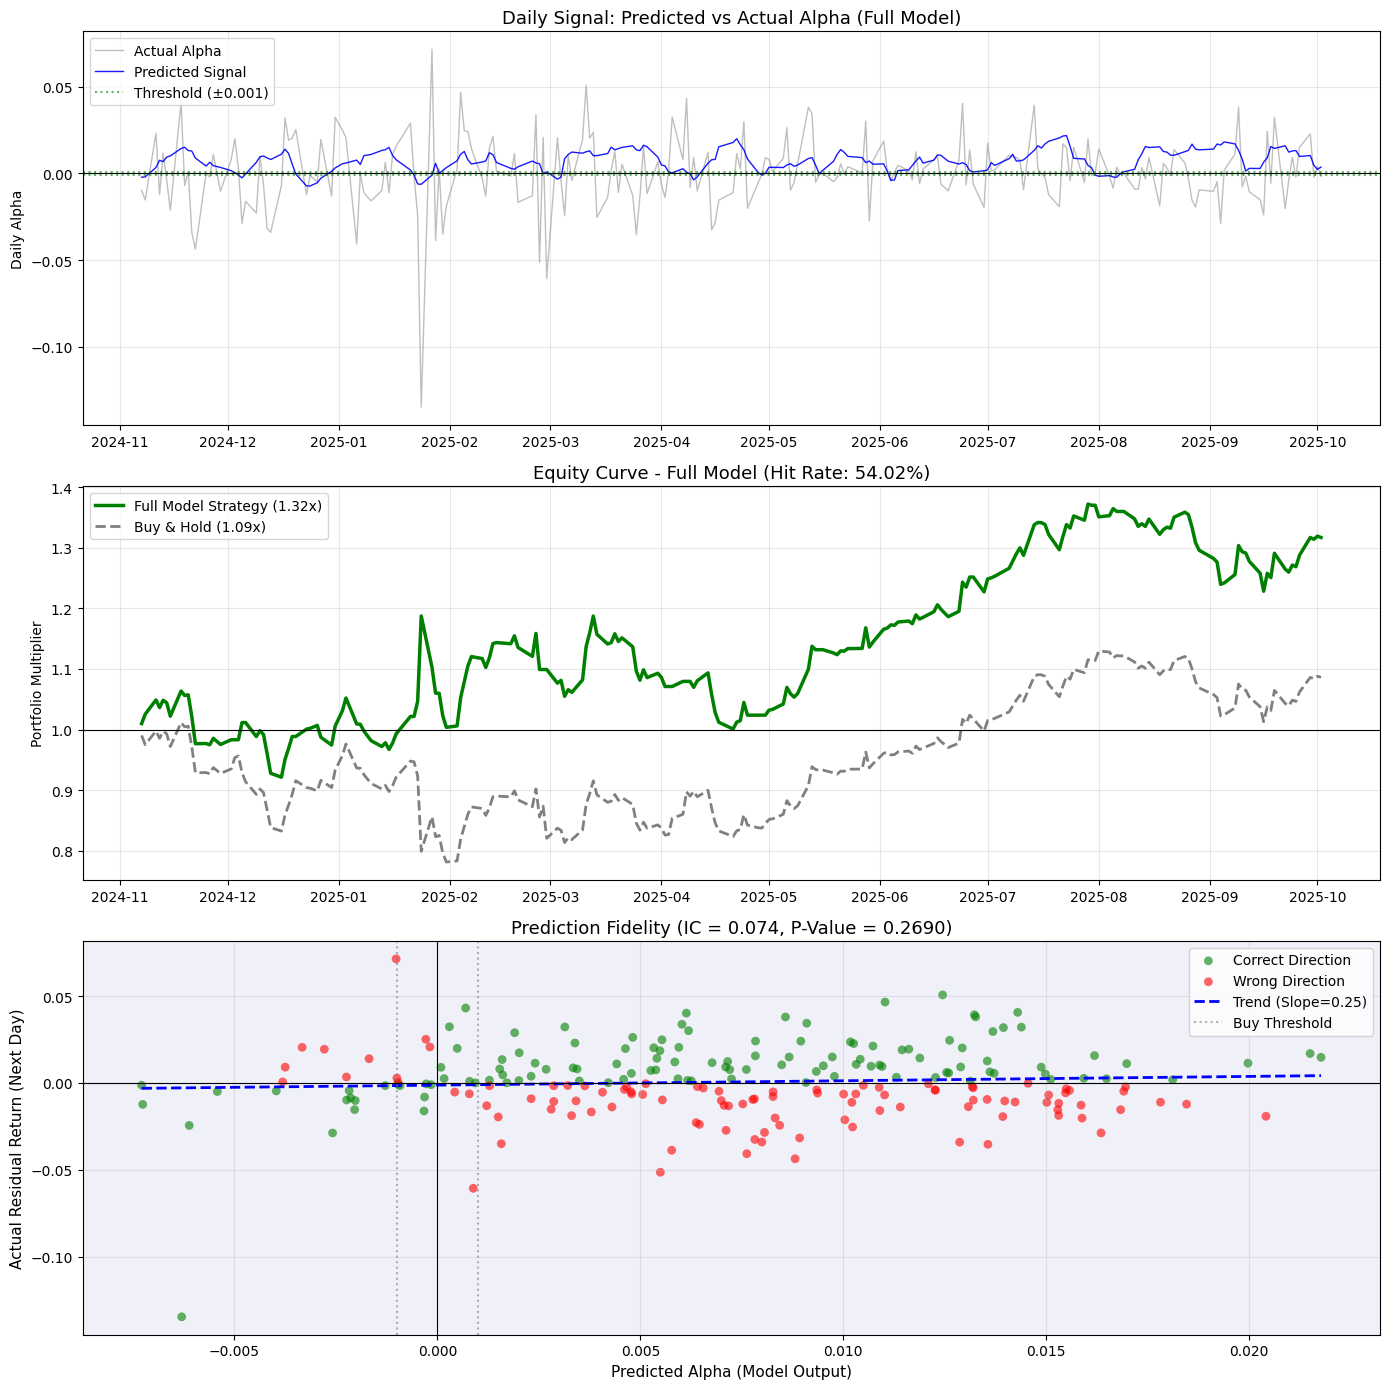

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import yfinance as yf
import warnings
import random
import os

warnings.filterwarnings('ignore')

# ==========================================
# 7. EVALUATION
# ==========================================
print("\nEvaluating Full Model...")
model.eval()
with torch.no_grad():
    xm, xn = X_m_te.to(device), X_n_te.to(device)
    pred_alpha = model(xm, xn).cpu().numpy().flatten()
    actual_alpha = y_res_te.cpu().numpy()

# Metrics
pred_dir = (pred_alpha > 0).astype(int)
true_dir = (actual_alpha > 0).astype(int)
hit_rate = accuracy_score(true_dir, pred_dir)

# Threshold Strategy
position = np.zeros_like(pred_alpha)
position[pred_alpha > THRESHOLD] = 1
position[pred_alpha < -THRESHOLD] = -1

returns = position * actual_alpha
cum_equity = (1 + returns).cumprod()
cum_buyhold = (1 + actual_alpha).cumprod()

# Information Coefficient (Correlation)
ic, p_value = stats.pearsonr(pred_alpha, actual_alpha)

# Linear regression for trend line
slope, intercept, r_value, _, _ = stats.linregress(pred_alpha, actual_alpha)

print(f"\n>>> FULL MODEL RESULTS <<<")
print(f"Hit Rate: {hit_rate:.2%}")
print(f"Information Coefficient (IC): {ic:.3f}")
print(f"P-Value: {p_value:.4f}")
print(f"Final Multiplier: {cum_equity[-1]:.3f}x ({(cum_equity[-1]-1)*100:+.1f}%)")
print(f"Buy & Hold: {cum_buyhold[-1]:.3f}x ({(cum_buyhold[-1]-1)*100:+.1f}%)")
print(f"Trades Taken: {np.sum(position != 0)} / {len(position)}")
print(f"\nFirst 5 predictions (reproducibility check): {pred_alpha[:5]}")

# ==========================================
# 8. VISUALIZATION (3 PLOTS)
# ==========================================
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# ----- PLOT 1: Daily Signal (Predicted vs Actual) -----
ax1 = axes[0]
ax1.plot(dates_te, actual_alpha, label='Actual Alpha', color='gray', alpha=0.5, linewidth=1)
ax1.plot(dates_te, pred_alpha, label='Predicted Signal', color='blue', alpha=0.9, linewidth=1)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.axhline(THRESHOLD, color='green', linestyle=':', alpha=0.6, label=f'Threshold (±{THRESHOLD})')
ax1.axhline(-THRESHOLD, color='green', linestyle=':', alpha=0.6)
ax1.set_title("Daily Signal: Predicted vs Actual Alpha (Full Model)", fontsize=13)
ax1.set_ylabel("Daily Alpha")
ax1.legend(loc='upper left')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.grid(True, alpha=0.3)

# ----- PLOT 2: Equity Curve (Multiplier) -----
ax2 = axes[1]
ax2.plot(dates_te, cum_equity, label=f'Full Model Strategy ({cum_equity[-1]:.2f}x)', color='green', linewidth=2.5)
ax2.plot(dates_te, cum_buyhold, label=f'Buy & Hold ({cum_buyhold[-1]:.2f}x)', color='gray', linestyle='--', linewidth=2)
ax2.axhline(1.0, color='black', linewidth=0.8, linestyle='-')
ax2.set_title(f"Equity Curve - Full Model (Hit Rate: {hit_rate:.2%})", fontsize=13)
ax2.set_ylabel("Portfolio Multiplier")
ax2.legend(loc='upper left')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.grid(True, alpha=0.3)

# ----- PLOT 3: Prediction Fidelity Scatter -----
ax3 = axes[2]

# Color points by correct/incorrect direction
correct_mask = (pred_alpha > 0) == (actual_alpha > 0)
ax3.scatter(pred_alpha[correct_mask], actual_alpha[correct_mask],
            c='green', alpha=0.6, s=40, label='Correct Direction', edgecolors='none')
ax3.scatter(pred_alpha[~correct_mask], actual_alpha[~correct_mask],
            c='red', alpha=0.6, s=40, label='Wrong Direction', edgecolors='none')

# Trend line
x_line = np.linspace(pred_alpha.min(), pred_alpha.max(), 100)
y_line = slope * x_line + intercept
ax3.plot(x_line, y_line, 'b--', linewidth=2, label=f'Trend (Slope={slope:.2f})')

# Reference lines
ax3.axhline(0, color='black', linewidth=0.8)
ax3.axvline(0, color='black', linewidth=0.8)
ax3.axvline(THRESHOLD, color='gray', linestyle=':', alpha=0.6)
ax3.axvline(-THRESHOLD, color='gray', linestyle=':', alpha=0.6, label='Buy Threshold')

ax3.set_xlabel("Predicted Alpha (Model Output)", fontsize=11)
ax3.set_ylabel("Actual Residual Return (Next Day)", fontsize=11)
ax3.set_title(f"Prediction Fidelity (IC = {ic:.3f}, P-Value = {p_value:.4f})", fontsize=13)
ax3.legend(loc='upper right')
ax3.set_facecolor('#f0f0f8')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Importing the best saved model

Device: cpu
Loading and preparing data...
Fetching YFinance data from 2021-07-01 to 2025-10-04...

Processing: 0. NVDA Only
Loading from: saved_models/0_NVDA_Only.pt
Model type: Standard
Features: 4 columns
>>> Alpha Mult: 1.079x | Raw Mult: 1.317x | Trades: 153

Processing: 1. Market Only
Loading from: saved_models/1_Market_Only.pt
Model type: Standard
Features: 10 columns
>>> Alpha Mult: 1.313x | Raw Mult: 1.400x | Trades: 187

Processing: 2. Market + SEC
Loading from: saved_models/2_Market_SEC.pt
Model type: Standard
Features: 14 columns
>>> Alpha Mult: 1.615x | Raw Mult: 1.701x | Trades: 161

Processing: 3. Market + News
Loading from: saved_models/3_Market_News.pt
Model type: Gated
Features: 11 columns
>>> Alpha Mult: 1.009x | Raw Mult: 1.026x | Trades: 204

Processing: 4. Full Model
Loading from: saved_models/4_Full_Model.pt
Model type: Gated
Features: 15 columns
>>> Alpha Mult: 1.545x | Raw Mult: 1.779x | Trades: 208


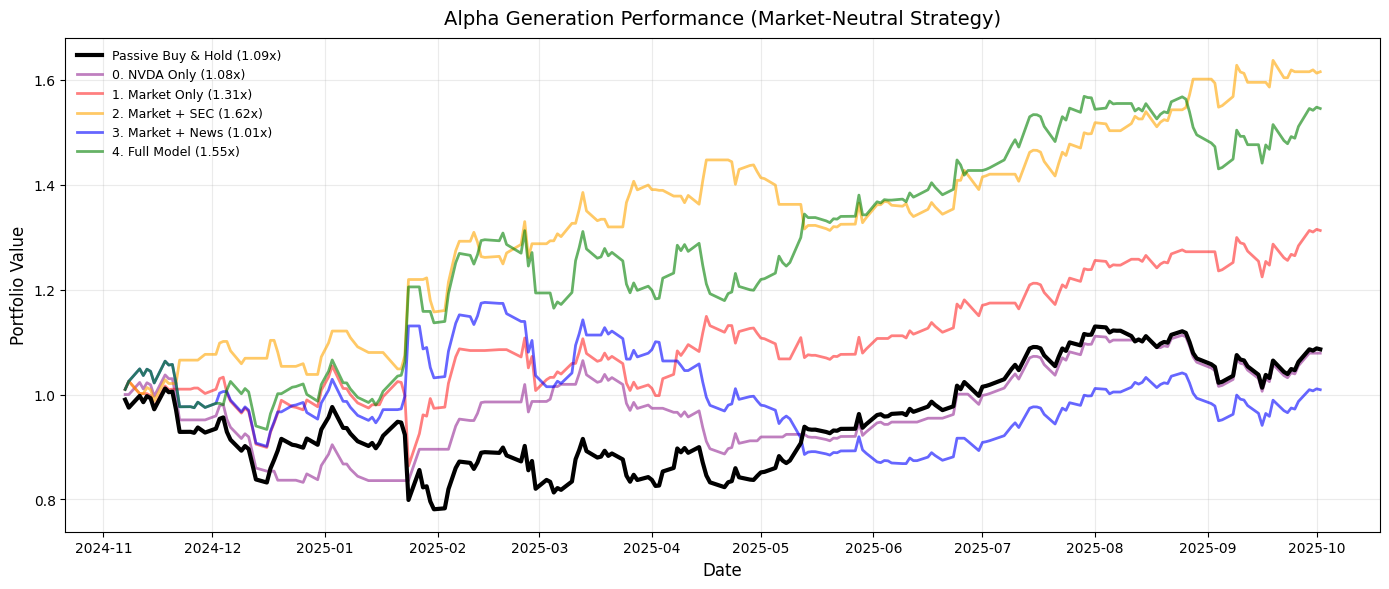

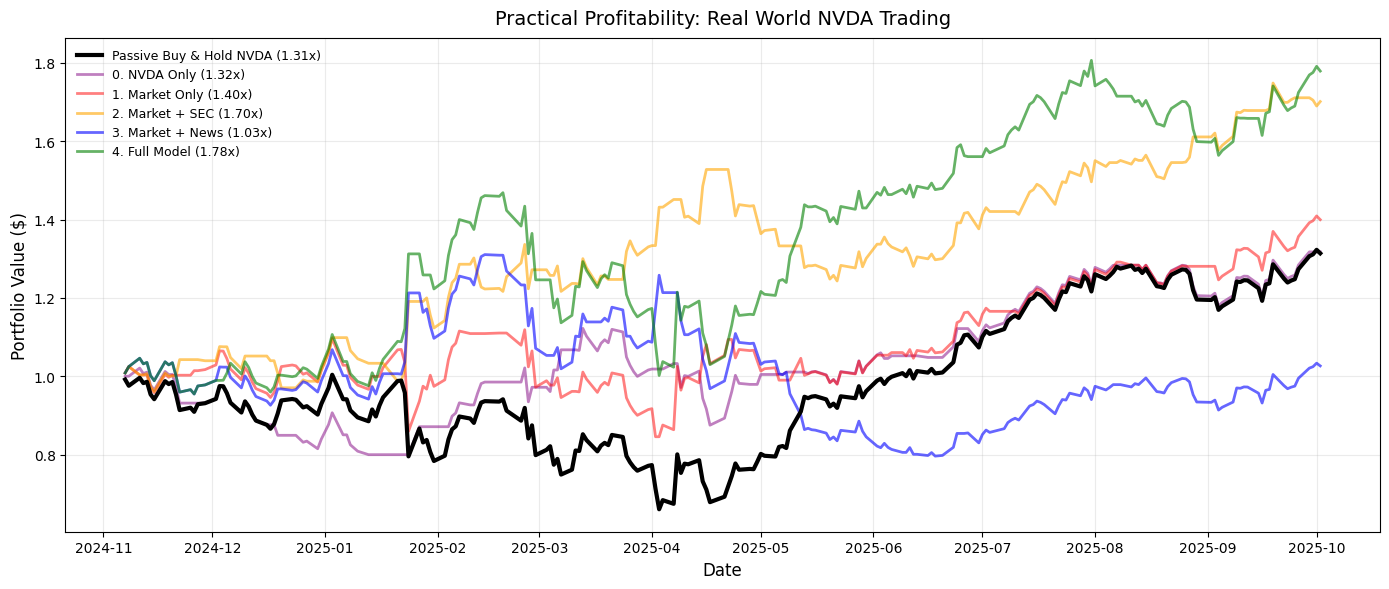


RESULTS SUMMARY
0. NVDA Only:
  Alpha Multiplier: 1.079x
  Raw Multiplier: 1.317x
  Total Trades: 153

1. Market Only:
  Alpha Multiplier: 1.313x
  Raw Multiplier: 1.400x
  Total Trades: 187

2. Market + SEC:
  Alpha Multiplier: 1.615x
  Raw Multiplier: 1.701x
  Total Trades: 161

3. Market + News:
  Alpha Multiplier: 1.009x
  Raw Multiplier: 1.026x
  Total Trades: 204

4. Full Model:
  Alpha Multiplier: 1.545x
  Raw Multiplier: 1.779x
  Total Trades: 208



In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import warnings
import random
import os

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 241
set_seed(SEED)

# ==========================================
# MODEL ARCHITECTURES (MUST MATCH TRAINING)
# ==========================================
class StandardLSTM(nn.Module):
    def __init__(self, mkt_dim, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(mkt_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.0)
        self.dropout = nn.Dropout(0.2)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Tanh()
        )
    def forward(self, x_m, x_n=None):
        lstm_out, (h_n, _) = self.lstm(x_m)
        state = self.dropout(h_n[-1])
        return self.head(state) * 0.1

class GatedNewsNet(nn.Module):
    def __init__(self, mkt_dim, news_dim=768, hidden_dim=128):
        super().__init__()
        self.market_lstm = nn.LSTM(mkt_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.0)
        self.lstm_dropout = nn.Dropout(0.2)
        self.news_reduce = nn.Linear(news_dim, hidden_dim)
        self.gate_fc = nn.Linear(hidden_dim * 2, 1)
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Tanh()
        )

    def forward(self, x_m, x_n):
        lstm_out, (h_n, _) = self.market_lstm(x_m)
        market_state = self.lstm_dropout(h_n[-1])
        news_reduced = F.relu(self.news_reduce(x_n))
        attn_scores = torch.bmm(news_reduced, market_state.unsqueeze(2))
        attn_weights = F.softmax(attn_scores, dim=1)
        news_context = torch.sum(news_reduced * attn_weights, dim=1)
        gate_input = torch.cat([market_state, news_context], dim=1)
        gate_val = torch.sigmoid(self.gate_fc(gate_input))
        gated_news = news_context * gate_val
        combined = torch.cat([market_state, gated_news], dim=1)
        return self.fusion(combined) * 0.1

# ==========================================
# DATA LOADING FUNCTIONS
# ==========================================
def fetch_yfinance_data(tickers, start_date, end_date):
    print(f"Fetching YFinance data from {start_date} to {end_date}...")
    try:
        data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', progress=False)
    except Exception as e:
        print(f"Error fetching data: {e}")
        return {}

    clean_data = {}
    if len(tickers) == 1:
        t = tickers[0]
        df = data.copy().reset_index()
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
            clean_data[t] = df[['Date', 'High', 'Low', 'Open', 'Volume']]
    else:
        for t in tickers:
            if t in data:
                df = data[t].copy().reset_index()
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
                    clean_data[t] = df[['Date', 'High', 'Low', 'Open', 'Volume']]
    return clean_data

def parse_embedding(emb_str):
    if isinstance(emb_str, str):
        cleaned = emb_str.replace('[', '').replace(']', '').replace('\n', ' ')
        try:
            return np.fromstring(cleaned, sep=' ')
        except:
            return np.zeros(768)
    return np.zeros(768)

def compute_technical_alpha(df):
    if 'High' not in df.columns: df['High'] = df['Close']
    if 'Low' not in df.columns: df['Low'] = df['Close']
    if 'Volume' not in df.columns: df['Volume'] = 1.0

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    prev_close = df['Close'].shift(1)
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - prev_close).abs()
    tr3 = (df['Low'] - prev_close).abs()
    df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['ATR'] = df['TR'].rolling(14).mean()

    period = 14
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    denom = (highest_high - lowest_low).replace(0, 1)
    df['WilliamsR'] = ((highest_high - df['Close']) / denom) * -100

    vol_avg = df['Volume'].rolling(20).mean().replace(0, 1)
    df['Vol_Shock'] = df['Volume'] / vol_avg

    return df.fillna(0)

def load_and_combine_csvs(train_paths, test_paths):
    combined = {}
    for ticker in train_paths.keys():
        train_df = pd.read_csv(train_paths[ticker])
        test_df = pd.read_csv(test_paths[ticker])
        train_df['Date'] = pd.to_datetime(train_df['Date'])
        test_df['Date'] = pd.to_datetime(test_df['Date'])
        full_df = pd.concat([train_df, test_df], ignore_index=True)
        full_df = full_df.drop_duplicates(subset='Date').sort_values('Date').reset_index(drop=True)
        combined[ticker] = full_df
    return combined

def prepare_full_dataset(combined_csvs, yf_start, yf_end, nvda_beta=1.2):
    tickers = list(combined_csvs.keys())
    yf_data = fetch_yfinance_data(tickers, yf_start, yf_end)

    dfs = {}
    for ticker, df in combined_csvs.items():
        df = df.copy()
        if ticker in yf_data:
            extra_data = yf_data[ticker]
            df = pd.merge(df, extra_data, on='Date', how='left')
            df[['High', 'Low', 'Open', 'Volume']] = df[['High', 'Low', 'Open', 'Volume']].ffill()

        df = df.sort_values('Date')
        if 'Close' not in df.columns and 'close' in df.columns:
            df.rename(columns={'close': 'Close'}, inplace=True)
        df['Close'] = df['Close'].replace(0, np.nan).ffill()
        df['Return'] = df['Close'].pct_change().fillna(0)

        dfs[ticker] = df[['Date', 'Close', 'Return']]

        if ticker == 'NVDA':
            df = compute_technical_alpha(df)
            if 'embedding' in df.columns:
                df['embedding_vec'] = df['embedding'].apply(parse_embedding)
            else:
                df['embedding_vec'] = [np.zeros(768) for _ in range(len(df))]

            if 'avg_impact_score' in df.columns:
                df['impact_log'] = np.log1p(df['avg_impact_score'].fillna(0) * 100)
            else:
                df['impact_log'] = 0

            sec_cols = ['Capital_Return_Policy', 'Earnings_Surprise', 'Legal_or_ESG_Issues', 'Strategic_Announcements']
            for sc in sec_cols:
                df[sc] = (df[sc] != 0).astype(int) if sc in df.columns else 0
            dfs['NVDA_RICH'] = df

    base = dfs['NVDA_RICH'].copy()
    base = base.merge(dfs['AMD'][['Date', 'Return']], on='Date', how='inner', suffixes=('', '_AMD'))
    base = base.merge(dfs['TSM'][['Date', 'Return']], on='Date', how='inner', suffixes=('', '_TSM'))
    base = base.merge(dfs['QQQ'][['Date', 'Return']], on='Date', how='inner', suffixes=('', '_QQQ'))

    base['Target_Residual'] = base['Return'] - (nvda_beta * base['Return_QQQ'])
    base['Spread_AMD'] = base['Return'] - base['Return_AMD']
    base['Spread_TSM'] = base['Return'] - base['Return_TSM']

    qqq_vol = base['Return_QQQ'].rolling(20).std()
    base['Vol_Ratio'] = (base['ATR'] / base['Close']) / qqq_vol.replace(0, 1)

    base.dropna(inplace=True)
    return base

def create_sequences_for_inference(df, feature_cols, lookback, scaler):
    """Create sequences for inference using saved scaler"""
    mkt_data = scaler.transform(df[feature_cols].values)
    news_data = np.stack(df['embedding_vec'].values)
    
    raw_returns = df['Return'].shift(-1).fillna(0).values
    targets_residual = df['Target_Residual'].shift(-1).fillna(0).values
    dates = df['Date'].iloc[lookback:-1].values

    X_m, X_n, y_res, raw_ret = [], [], [], []
    for i in range(len(df) - lookback - 1):
        X_m.append(mkt_data[i : i+lookback])
        X_n.append(news_data[i : i+lookback])
        y_res.append(targets_residual[i + lookback])
        raw_ret.append(raw_returns[i + lookback])

    return (torch.tensor(np.array(X_m), dtype=torch.float32),
            torch.tensor(np.array(X_n), dtype=torch.float32),
            torch.tensor(np.array(y_res), dtype=torch.float32),
            np.array(raw_ret),
            dates)

def create_sequences_for_training(df, feature_cols, lookback):
    """Create sequences for training with new scaler"""
    scaler = StandardScaler()
    mkt_data = scaler.fit_transform(df[feature_cols].values)
    news_data = np.stack(df['embedding_vec'].values)
    
    raw_returns = df['Return'].shift(-1).fillna(0).values
    targets_residual = df['Target_Residual'].shift(-1).fillna(0).values

    X_m, X_n, y_res, raw_ret = [], [], [], []
    for i in range(len(df) - lookback - 1):
        X_m.append(mkt_data[i : i+lookback])
        X_n.append(news_data[i : i+lookback])
        y_res.append(targets_residual[i + lookback])
        raw_ret.append(raw_returns[i + lookback])

    return (torch.tensor(np.array(X_m), dtype=torch.float32),
            torch.tensor(np.array(X_n), dtype=torch.float32),
            torch.tensor(np.array(y_res), dtype=torch.float32),
            np.array(raw_ret)), scaler

class StockDataset(Dataset):
    def __init__(self, xm, xn, y):
        self.xm, self.xn, self.y = xm, xn, y
    def __len__(self): return len(self.xm)
    def __getitem__(self, i): return self.xm[i], self.xn[i], self.y[i]

def directional_huber_loss(pred, target, lambda_dir=2.0):
    """
    Custom loss function designed to penalize directional errors more 
    heavily than magnitude errors. This is critical for trading signals 
    where the sign of the prediction is more important than the exact value.
    """
    # Standard Huber loss for robust regression
    huber = F.huber_loss(pred, target, reduction='none')
    
    # Identify where the predicted direction differs from actual direction
    sign_mismatch = (torch.sign(pred) != torch.sign(target)).float()
    
    # Apply a penalty multiplier (lambda_dir) to directional mismatches
    loss = huber * (1 + lambda_dir * sign_mismatch)
    return loss.mean()

# ==========================================
# MAIN EXECUTION
# ==========================================
# Configuration
TRAIN_PATHS = {
    'AMD': "dataset/amd_train.csv",
    'NVDA': "dataset/nvidia_train.csv",
    'QQQ': "dataset/qqq_train.csv",
    'TSM': "dataset/tsm_train.csv"
}
TEST_PATHS = {
    'AMD': "dataset/amd_test.csv",
    'NVDA': "dataset/nvidia_test.csv",
    'QQQ': "dataset/qqq_test.csv",
    'TSM': "dataset/tsm_test.csv"
}

TEST_START = '2024-10-10'
YF_START = '2021-07-01'
YF_END = '2025-10-04'

# Model paths - UPDATE THESE TO YOUR FOLDER
MODEL_FOLDER = "saved_models"  # Change to "saved_models_new" if needed

# Feature configurations
NVDA_ONLY_COLS = ['Return', 'RSI', 'WilliamsR', 'Vol_Shock']
BASE_MKT_COLS = ['Return', 'Return_AMD', 'Return_TSM', 'Return_QQQ',
                 'Spread_AMD', 'Spread_TSM',
                 'RSI', 'Vol_Ratio', 'WilliamsR', 'Vol_Shock']
SEC_COLS = ['Capital_Return_Policy', 'Earnings_Surprise', 'Legal_or_ESG_Issues', 'Strategic_Announcements']

MODEL_CONFIGS = {
    "0. NVDA Only": {"path": f"{MODEL_FOLDER}/0_NVDA_Only.pt", "train": False},
    "1. Market Only": {"path": f"{MODEL_FOLDER}/1_Market_Only.pt", "train": False},
    "2. Market + SEC": {"path": f"{MODEL_FOLDER}/2_Market_SEC.pt", "train": False},
    "3. Market + News": {"path": f"{MODEL_FOLDER}/3_Market_News.pt", "train": False},
    "4. Full Model": {"path": f"{MODEL_FOLDER}/4_Full_Model.pt", "train": False}
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load data
print("Loading and preparing data...")
combined_csvs = load_and_combine_csvs(TRAIN_PATHS, TEST_PATHS)
full_df = prepare_full_dataset(combined_csvs, YF_START, YF_END)

# Split into train and test
TRAIN_END = '2024-10-04'
train_df = full_df[full_df['Date'] <= TRAIN_END].copy().reset_index(drop=True)
test_df = full_df[full_df['Date'] >= TEST_START].copy().reset_index(drop=True)

results_store = {}
LOOKBACK = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 90

# Load and evaluate each model
for model_name, config in MODEL_CONFIGS.items():
    print(f"\n{'='*50}")
    print(f"Processing: {model_name}")
    
    if config.get("train", False):
        # NVDA Only - needs training
        print("Training NVDA Only model...")
        set_seed(SEED)
        
        feature_cols = config["features"]
        (X_m_tr, X_n_tr, y_res_tr, _), scaler = create_sequences_for_training(train_df, feature_cols, LOOKBACK)
        
        g = torch.Generator()
        g.manual_seed(SEED)
        train_loader = DataLoader(
            StockDataset(X_m_tr, X_n_tr, y_res_tr),
            batch_size=BATCH_SIZE,
            shuffle=True,
            generator=g,
            num_workers=0
        )
        
        model = StandardLSTM(len(feature_cols)).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        
        model.train()
        for epoch in range(EPOCHS):
            total_loss = 0
            for xm, xn, y_res in train_loader:
                xm, xn, y_res = xm.to(device), xn.to(device), y_res.to(device)
                optimizer.zero_grad()
                pred = model(xm, xn).squeeze()
                loss = directional_huber_loss(pred, y_res)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                total_loss += loss.item()
            scheduler.step(total_loss)
            if (epoch+1) % 30 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS}: Loss {total_loss/len(train_loader):.5f}")
        
        model.eval()
        
        # Save the trained NVDA Only model
        model_save_path = f"{MODEL_FOLDER}/0_NVDA_Only.pt"
        torch.save(
            {
                "model_type": "Standard",
                "market_dim": len(feature_cols),
                "feature_cols": feature_cols,
                "lookback": LOOKBACK,
                "state_dict": model.state_dict(),
                "scaler": scaler,
                "seed": SEED
            },
            model_save_path
        )
        print(f"Model saved to {model_save_path}")
        
    else:
        # Load pre-trained model
        model_path = config["path"]
        print(f"Loading from: {model_path}")
        
        if not os.path.exists(model_path):
            print(f"WARNING: Model file not found at {model_path}")
            continue
        
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        
        model_type = checkpoint['model_type']
        market_dim = checkpoint['market_dim']
        feature_cols = checkpoint['feature_cols']
        lookback = checkpoint['lookback']
        scaler = checkpoint['scaler']
        
        print(f"Model type: {model_type}")
        print(f"Features: {len(feature_cols)} columns")
        
        # Create model
        if model_type == "Standard":
            model = StandardLSTM(market_dim).to(device)
        else:
            model = GatedNewsNet(market_dim).to(device)
        
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
        LOOKBACK = lookback
    
    # Prepare test data with the same features
    X_m_te, X_n_te, y_res_te, raw_nvda_te, dates_te = create_sequences_for_inference(
        test_df, feature_cols, LOOKBACK, scaler
    )
    
    # Make predictions
    with torch.no_grad():
        xm, xn = X_m_te.to(device), X_n_te.to(device)
        pred_alpha = model(xm, xn).cpu().numpy().flatten()
        actual_alpha = y_res_te.cpu().numpy()
        
        THRESHOLD = 0.001
        position = np.zeros_like(pred_alpha)
        position[pred_alpha > THRESHOLD] = 1
        position[pred_alpha < -THRESHOLD] = -1
        
        # Calculate returns
        ret_alpha = position * actual_alpha
        cum_alpha = (1 + ret_alpha).cumprod()
        
        ret_raw = position * raw_nvda_te
        cum_raw = (1 + ret_raw).cumprod()
        
        results_store[model_name] = {
            "Multiplier_Alpha": cum_alpha[-1],
            "Multiplier_Raw": cum_raw[-1],
            "Trades": np.sum(position != 0),
            "Cum_Equity_Alpha": cum_alpha,
            "Cum_Equity_Raw": cum_raw
        }
        
        print(f">>> Alpha Mult: {cum_alpha[-1]:.3f}x | Raw Mult: {cum_raw[-1]:.3f}x | Trades: {np.sum(position != 0)}")

# ==========================================
# PLOTTING
# ==========================================
dates = dates_te

# Benchmarks
bh_alpha = (1 + y_res_te.cpu().numpy()).cumprod()
bh_raw = (1 + raw_nvda_te).cumprod()

# ========== PLOT 1: ALPHA GENERATION ==========
plt.figure(figsize=(14, 6))

# Plot baseline first with higher visibility
plt.plot(dates, bh_alpha, linestyle="-", color="black", 
         linewidth=3, label=f"Passive Buy & Hold ({bh_alpha[-1]:.2f}x)", zorder=10)

# Other strategies with reduced opacity
colors = ['purple', 'red', 'orange', 'blue', 'green']
alphas = [0.5, 0.5, 0.6, 0.6, 0.6]

for i, (name, res) in enumerate(results_store.items()):
    plt.plot(dates, res['Cum_Equity_Alpha'], 
             color=colors[i], linewidth=2, alpha=alphas[i],
             label=f"{name} ({res['Multiplier_Alpha']:.2f}x)")

plt.title("Alpha Generation Performance (Market-Neutral Strategy)", fontsize=14, pad=10)
plt.ylabel("Portfolio Value", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(loc="upper left", frameon=False, fontsize=9)
plt.grid(True, alpha=0.25)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()

# ========== PLOT 2: REAL WORLD PROFIT ==========
plt.figure(figsize=(14, 6))

# Plot baseline first with higher visibility
plt.plot(dates, bh_raw, linestyle="-", color="black", 
         linewidth=3, label=f"Passive Buy & Hold NVDA ({bh_raw[-1]:.2f}x)", zorder=10)

# Other strategies with reduced opacity
for i, (name, res) in enumerate(results_store.items()):
    plt.plot(dates, res['Cum_Equity_Raw'], 
             color=colors[i], linewidth=2, alpha=alphas[i],
             label=f"{name} ({res['Multiplier_Raw']:.2f}x)")

plt.title("Practical Profitability: Real World NVDA Trading", fontsize=14, pad=10)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(loc="upper left", frameon=False, fontsize=9)
plt.grid(True, alpha=0.25)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
for name, res in results_store.items():
    print(f"{name}:")
    print(f"  Alpha Multiplier: {res['Multiplier_Alpha']:.3f}x")
    print(f"  Raw Multiplier: {res['Multiplier_Raw']:.3f}x")
    print(f"  Total Trades: {res['Trades']}")
    print()